# Prototype hybrid matrix factorization model for drug reccomendations using PyTorch

## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill

from scipy.stats import pearsonr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader


from sklearn import metrics

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset, evaluate_predictions

## Load KINOMEscan preprocessed dataset with intersection of proteins screened for drugs

In [3]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)

Kinases Dataset <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset. 
- Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
mutations in 18 genes. Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
- Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
- Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered 


## Data preprocessing

#### Establish response data for samples (drug-cell line pairs)

In [4]:
response_df = full_dataset.response_data.copy()
print(response_df.shape, response_df.COSMIC_ID.nunique())
response_df.head(3)

(55936, 3) 987


,DRUG_ID,COSMIC_ID,AUC
2748,29,683665,0.945160
2749,29,684055,0.926046
2750,29,684057,0.934873


#### Establish cell line features data

In [5]:
cell_line_data_df = full_dataset.full_cell_lines_data.copy()
print(cell_line_data_df.shape)
cell_line_data_df.head(3)

(922, 225)


,cell_line_id,PRKX_exp,TIE1_exp,BMPR2_exp,PKMYT1_exp,ABL2_exp,PLK1_exp,ACVR1_exp,MAP3K4_mut,SRPK1_exp,...,Tissue_lung_SCLC,Tissue_lymphoma,Tissue_myeloma,Tissue_nervous_system,Tissue_neuroblastoma,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system
cell_line_id,,,,,,,,,,,,,,,,,,,,,
906826,906826,4.787607,3.056350,6.395463,5.550737,5.492917,3.853142,4.384087,0,7.410108,...,0,0,0,0,0,0,0,0,0,0
687983,687983,5.001763,3.125097,6.634672,5.399054,5.113815,4.218736,4.786061,0,7.776150,...,1,0,0,0,0,0,0,0,0,0
910927,910927,5.459631,2.989998,7.945827,5.541005,4.519127,3.694307,4.414635,0,7.079021,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
print(len(missing_cell_lines))

66


In [7]:
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_df.index = cell_line_data_df.cell_line_id
cell_line_data_df = cell_line_data_df.drop("cell_line_id", axis=1)

In [8]:
# Extract response only for cell lines for which features are present
print(response_df.shape)
response_df = response_df[~response_df.COSMIC_ID.isin(missing_cell_lines)]
print(response_df.shape)

(55936, 3)
(52730, 3)


#### Establish drug features data

In [9]:
drug_data_df = full_dataset.drugs_data.copy()
print(drug_data_df.shape)
# Convert drug index from LINCS name to GDSC drug ID
drug_data_df.index = drug_data_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)
drug_data_df.head(3)

(74, 294)


Protein,MAPKAPK2,MARK1,CAMKK2,MARK2,TGFBR1,ERK5,EPHA7,MK01,RAF1,TNNI3K,...,KGP1,ZAP70,ERK3,BLK,MYLK2,KPCD3,FGFR3,ACVR1,GSK3A,KPCD
Small Molecule,,,,,,,,,,,,,,,,,,,,,
1242,100.0,83.0,88.0,96.0,57.0,100.0,92.0,64.0,100.0,77.0,...,99.0,86.0,98.0,57.0,80.0,12.0,95.0,1.9,100.0,100.0
86,100.0,100.0,2.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.7,100.0,100.0,100.0,100.0,1.6,100.0,100.0,1.0,0.9
29,100.0,100.0,28.0,92.0,100.0,100.0,84.0,100.0,2.3,15.0,...,100.0,100.0,100.0,1.0,100.0,88.0,100.0,100.0,100.0,89.0


In [10]:
# Search for drugs present in response data, but missing the drug features
missing_drugs = []
for drug_id in response_df.DRUG_ID.unique():
    if drug_id not in drug_data_df.index:
        print(drug_id)
        missing_drugs.append(drug_id)
print(len(missing_drugs))

0


#### Split drug response data into training/validation/test 

In [11]:
print(cell_line_data_df.shape, drug_data_df.index.nunique(), cell_line_data_df.index.nunique())
print(response_df.shape, response_df.DRUG_ID.nunique(), response_df.COSMIC_ID.nunique())

(922, 224) 74 922
(52730, 3) 74 921


In [12]:
# Split the data into train, validation and test, separating subset of cell lines
# val_ratio = 0.25
# num_separated_cell_lines = 30

# # Extract samples with cell lines separated from training
# separated_cell_lines = list(np.random.choice(response_df.COSMIC_ID.unique(), size=20))
# separated_samples = response_df[response_df.COSMIC_ID.isin(separated_cell_lines)]

# # Extract rest
# rest = response_df[~response_df.COSMIC_ID.isin(separated_cell_lines)]

# train_samples = rest[int(val_ratio * response_df.shape[0]):]
# val_samples = rest[:int(val_ratio * response_df.shape[0])]

# print(train_samples.shape, val_samples.shape, separated_samples.shape)

In [13]:
# Shuffle all the samples
response_df = response_df.sample(frac=1., random_state=2)

In [14]:
# Split the data into train, validation and test set, separating distinct cell lines
# Specify how many cell lines go to validation and test sets
num_cell_lines_val = 100
num_cell_lines_test = 100

# Extract test cell lines samples
cell_lines_test = list(np.random.choice(response_df.COSMIC_ID.unique(), size=num_cell_lines_test,
                                       replace=False))
samples_test = response_df[response_df.COSMIC_ID.isin(cell_lines_test)]

# Extract rest
rest = response_df[~response_df.COSMIC_ID.isin(cell_lines_test)]

# Extract validation cell lines samples
cell_lines_val = list(np.random.choice(rest.COSMIC_ID.unique(), size=num_cell_lines_val,
                                       replace=False))
samples_val = rest[rest.COSMIC_ID.isin(cell_lines_val)]

# Extract rest (training set)
samples_train = rest[~rest.COSMIC_ID.isin(cell_lines_val)]

print(response_df.shape, samples_train.shape, samples_val.shape, samples_test.shape)
print(response_df.COSMIC_ID.nunique(), samples_train.COSMIC_ID.nunique(), samples_val.COSMIC_ID.nunique(),
     samples_test.COSMIC_ID.nunique())

(52730, 3) (41183, 3) (5866, 3) (5681, 3)
921 721 100 100


In [15]:
set(samples_test.COSMIC_ID.unique()).intersection(set(samples_val.COSMIC_ID.unique()))

set()

#### Normalize / standardize the data

In [16]:
# Cell line data
cols_subset = [col for col in list(cell_line_data_df) if col.endswith("_exp")]
rows_subset = [x for x in cell_line_data_df.index if x not in cell_lines_test + cell_lines_val]

cell_line_data_df = Dataset.standardize_data(cell_line_data_df, cols_subset=cols_subset,
                                            rows_subset=rows_subset)
print(cell_line_data_df.shape, cell_line_data_df.mean().mean(),
     cell_line_data_df.std().sum())

(922, 224) 0.0037008063085167226 193.8143783941021


In [17]:
# Drug data
print(drug_data_df.shape)
drug_data_df = Dataset.standardize_data(drug_data_df)
print(drug_data_df.shape, drug_data_df.mean().mean(),
     drug_data_df.std().sum())

(74, 294)
(74, 294) 2.196104424744604e-17 294.0


## Model definition

In [80]:
# Model definition
class LinearMatrixFactorizationWithFeatures(torch.nn.Module):
    def __init__(self, drug_input_dim, cell_line_input_dim, output_dim, 
                 out_activation_func=None,
                 drug_bias=True,
                 cell_line_bias=True):
        super(LinearMatrixFactorizationWithFeatures, self).__init__()
        self.drug_linear = torch.nn.Linear(drug_input_dim, output_dim, bias=drug_bias)
        self.cell_line_linear = torch.nn.Linear(cell_line_input_dim, output_dim, bias=cell_line_bias)
        self.out_activation = out_activation_func
        
    def forward(self, drug_features, cell_line_features):
        drug_outputs = self.drug_linear(drug_features)
        cell_line_outputs = self.cell_line_linear(cell_line_features)
        
        final_outputs = torch.sum(torch.mul(drug_outputs, cell_line_outputs), dim=1).view(-1, 1)
        if self.out_activation:
            return self.out_activation(final_outputs)
        return final_outputs

## Model training

In [81]:
# Take sample of whole training data if needed
samples_train = samples_train.sample(2000, random_state=2)
print(samples_train.shape, samples_train["AUC"].mean())

(2000, 3) 0.832467058


#### Specify hyperparameters

In [82]:
# Specify shape of input
drug_dim = drug_data_df.shape[1]
cell_line_dim = cell_line_data_df.shape[1]

# Specify learning hyperparameters
learning_rate = 0.001
epochs = 50
output_dim = 10
batch_size = 32
no_batches = samples_train.shape[0] // batch_size + 1

model = LinearMatrixFactorizationWithFeatures(drug_dim, cell_line_dim, output_dim,
                                             drug_bias=True,
                                             cell_line_bias=True,
                                             out_activation_func=torch.sigmoid)

# Define loss function and optimizer
weight_decay = 0.
reg_lambda = 0.001

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Display text representation of model
model

LinearMatrixFactorizationWithFeatures(
  (drug_linear): Linear(in_features=294, out_features=10, bias=True)
  (cell_line_linear): Linear(in_features=224, out_features=10, bias=True)
)

torch.Size([10, 294]) tensor(1.7830, grad_fn=<NormBackward0>)
torch.Size([10]) tensor(0.1255, grad_fn=<NormBackward0>)
torch.Size([10, 224]) tensor(1.7848, grad_fn=<NormBackward0>)
torch.Size([10]) tensor(0.1051, grad_fn=<NormBackward0>)


In [88]:
model.out_activation(torch.tensor(0.))

tensor(0.5000)

#### Training loop

In [89]:
# Training the model
model.train()
for epoch in range(epochs):
    for batch in range(no_batches):
        # Separate response variable batch
        if batch != no_batches:
            samples_batch = samples_train.iloc[batch * batch_size:(batch + 1) * batch_size]
        else:
            samples_batch = samples_train.iloc[batch * batch_size:]
            
        # Extract output variable batch
        y_batch = torch.from_numpy(samples_batch["AUC"].values).view(-1, 1)
        
        # Extract cell lines IDs for which data shall be extracted
        cl_ids = samples_batch["COSMIC_ID"].values
        # Extract corresponding cell line data
        cell_line_input_batch = cell_line_data_df.loc[cl_ids].values
        cell_line_input_batch = torch.from_numpy(cell_line_input_batch)
        
        # Extract drug IDs for which data shall be extracted
        drug_ids = samples_batch["DRUG_ID"].values
        # Extract corresponding drug data
        drug_input_batch = drug_data_df.loc[drug_ids].values
        drug_input_batch = torch.from_numpy(drug_input_batch)
        
        # Clear gradient buffers because we don't want to accummulate gradients 
        optimizer.zero_grad()
        
        # Perform forward pass
        batch_output = model(drug_input_batch.float(), cell_line_input_batch.float())
        
        reg = 0
        for param in model.parameters():
            reg += 0.5 * (param ** 2).sum()  # L2 norm
        
        # Compute the loss for this batch
        loss = criterion(batch_output, y_batch.float()) + reg_lambda * reg
        # Get the gradients w.r.t. the parameters
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        #print("Epoch {}, batch {}, loss: {:.3f}".format(epoch + 1, batch + 1, loss.item()))
    print("Epoch {}, loss: {:.4f}".format(epoch + 1, loss.item()))

Epoch 1, loss: 0.2138
Epoch 2, loss: 0.2047
Epoch 3, loss: 0.1963
Epoch 4, loss: 0.1885
Epoch 5, loss: 0.1814
Epoch 6, loss: 0.1750
Epoch 7, loss: 0.1693
Epoch 8, loss: 0.1642
Epoch 9, loss: 0.1597
Epoch 10, loss: 0.1556
Epoch 11, loss: 0.1521
Epoch 12, loss: 0.1488
Epoch 13, loss: 0.1460
Epoch 14, loss: 0.1433
Epoch 15, loss: 0.1410
Epoch 16, loss: 0.1388
Epoch 17, loss: 0.1368
Epoch 18, loss: 0.1350
Epoch 19, loss: 0.1333
Epoch 20, loss: 0.1317
Epoch 21, loss: 0.1303
Epoch 22, loss: 0.1289
Epoch 23, loss: 0.1276
Epoch 24, loss: 0.1265
Epoch 25, loss: 0.1253
Epoch 26, loss: 0.1243
Epoch 27, loss: 0.1233
Epoch 28, loss: 0.1224
Epoch 29, loss: 0.1215
Epoch 30, loss: 0.1206
Epoch 31, loss: 0.1199
Epoch 32, loss: 0.1191
Epoch 33, loss: 0.1184
Epoch 34, loss: 0.1177
Epoch 35, loss: 0.1170
Epoch 36, loss: 0.1164
Epoch 37, loss: 0.1157
Epoch 38, loss: 0.1151
Epoch 39, loss: 0.1146
Epoch 40, loss: 0.1140
Epoch 41, loss: 0.1135
Epoch 42, loss: 0.1129
Epoch 43, loss: 0.1124
Epoch 44, loss: 0.11

## Model evaluation

In [90]:
# Establish mean of AUC in training data for baseline model evaluation
mean_training_auc = samples_train["AUC"].mean()

#### Evaluate on training data

In [91]:
# Do some sample predictions on trainig data
# Sample data points
sample = samples_train.sample(3)
sample

,DRUG_ID,COSMIC_ID,AUC
214171,1049,907790,0.973409
222935,1061,1290905,0.986523
195805,1022,910903,0.625504


In [92]:
# Do some predictions on training data
cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
print(predicted, predicted.shape)

tensor([[0.3788],
        [0.4570],
        [0.5779]]) torch.Size([3, 1])


In [93]:
# Do predictions manually
drug_out = torch.from_numpy(drug_input[0].reshape(-1, 294)).float() @ model.drug_linear.weight.t() + \
                                                                    model.drug_linear.bias
cl_out = torch.from_numpy(cl_input[0].reshape(-1, 224)).float() @ model.cell_line_linear.weight.t() + \
                                                            model.cell_line_linear.bias
final_out = torch.zeros(drug_out.shape[0])
for k in range(drug_out.shape[1]):
    final_out = final_out + drug_out[:, k] * cl_out[:, k]
print(final_out.shape, final_out)

torch.Size([1]) tensor([-0.4947], grad_fn=<AddBackward0>)


In [94]:
# Predict on training data
sample = samples_train.iloc[:]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([mean_training_auc] * sample.shape[0])

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()
print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.reshape(-1))

torch.Size([2000, 1]) tensor(0.9092) tensor(0.0773) tensor(0.5378)
Baseline scores:
RMSE: 0.1832172409697369
Correlation: (nan, nan)

Model scores:
tensor(0.9092) tensor(0.0773) tensor(0.5378)
RMSE: 0.3603673134686759
Correlation: (0.13743440517801775, 6.755210541907133e-10)


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [95]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    mean_true_auc = df["AUC"].mean()
    dummy_preds = [mean_true_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(74, 6) 74
0.0718936213087171


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [99]:
corrs_per_drug.sort_values("Model correlation", ascending=False).head()

,Drug ID,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
69,94,0.425004,0.732932,0.144999,NaN,7
71,86,0.302905,0.554130,0.134080,NaN,16
44,1799,0.303762,0.550416,0.143002,NaN,27
64,56,0.313615,0.528029,0.268472,NaN,9
65,1161,0.305534,0.498945,0.109356,NaN,17


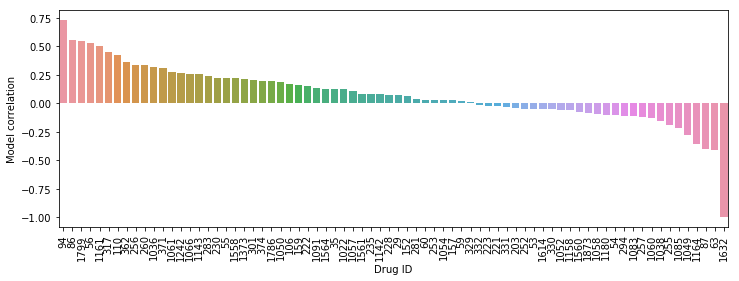

In [96]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

#### Evaluation on validation set

In [63]:
print(samples_val.shape)

(5866, 3)


In [64]:
# Predict on validation data and evaluate
sample = samples_val[:]
y_true = sample["AUC"].values

# Create baseline predictions(mean AUC)
mean_preds = np.array([mean_training_auc] * sample.shape[0])

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.shape, predicted.max(), predicted.min(), predicted.mean())
print("Baseline scores:")
evaluate_predictions(y_true, mean_preds)
print()

print("Model scores:")
print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.view(-1))

torch.Size([5866, 1]) tensor(2.3811) tensor(-4.0338) tensor(0.5972)
Baseline scores:
RMSE: 0.18352162371871672
Correlation: (nan, nan)

Model scores:
tensor(2.3811) tensor(-4.0338) tensor(0.5972)
RMSE: 0.5463192625697165
Correlation: (0.11624790267467003, 4.1911948227930274e-19)


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [65]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    mean_true_auc = df["AUC"].mean()
    dummy_preds = [mean_true_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(74, 6) 74
0.032948457949925736


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


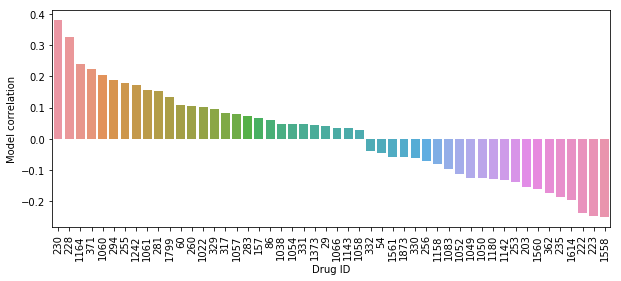

In [66]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

#### Evaluate on unseen cell lines

In [67]:
# Predict on unseen cell lines and evaluate
sample = samples_test
y_true = sample["AUC"].values

cl_input = cell_line_data_df.loc[sample["COSMIC_ID"].values].values
drug_input = drug_data_df.loc[sample["DRUG_ID"].values].values

model.eval()
with torch.no_grad():
    predicted = model(torch.from_numpy(drug_input).float(), 
                     torch.from_numpy(cl_input).float())
    
del cl_input, drug_input

print(predicted.max(), predicted.min(), predicted.mean())
evaluate_predictions(y_true, predicted.view(-1))

tensor(2.1030) tensor(-3.6626) tensor(0.5473)
RMSE: 0.5226993060739263
Correlation: (0.1527588729585517, 5.247973552308591e-31)


In [68]:
# Compute evaluation metrics per drug
sample_with_predictions = sample.copy()
sample_with_predictions["Predicted AUC"] = predicted.numpy()

drugs = []
model_corrs = []
model_rmses = []
dummy_corrs = []
dummy_rmses = []
no_samples = []

for drug in sample_with_predictions.DRUG_ID.unique():
    df = sample_with_predictions[sample_with_predictions.DRUG_ID == drug]
    mean_true_auc = df["AUC"].mean()
    dummy_preds = [mean_true_auc] * df.shape[0]
    dummy_rmse = metrics.mean_squared_error(df["AUC"], dummy_preds) ** 0.5
    dummy_corr = pearsonr(df["AUC"], dummy_preds)
    
    model_rmse = metrics.mean_squared_error(df["AUC"], df["Predicted AUC"]) ** 0.5
    model_corr = pearsonr(df["AUC"], df["Predicted AUC"])
    
    drugs.append(drug)
    dummy_rmses.append(dummy_rmse)
    dummy_corrs.append(dummy_corr[0])
    
    model_rmses.append(model_rmse)
    model_corrs.append(model_corr[0])
    
    no_samples.append(df.COSMIC_ID.nunique())

corrs_per_drug = pd.DataFrame()
corrs_per_drug["Drug ID"] = drugs
corrs_per_drug["Model RMSE"] = model_rmses
corrs_per_drug["Model correlation"] = model_corrs

corrs_per_drug["Dummy RMSE"] = dummy_rmses
corrs_per_drug["Dummy correlation"] = dummy_corrs
corrs_per_drug["No. samples"] = no_samples

print(corrs_per_drug.shape, corrs_per_drug["Drug ID"].nunique())
print(corrs_per_drug["Model correlation"].median())

(74, 6) 74
0.05985532956288445


/home/krzysztof/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


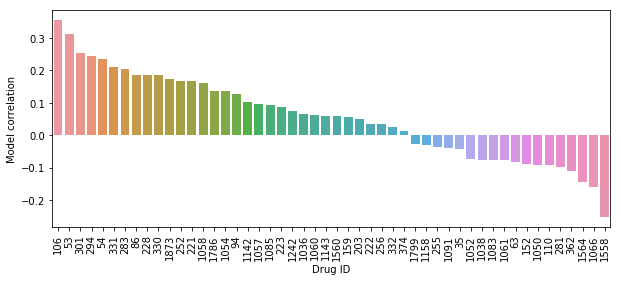

In [69]:
# Plot per-drug results
plt.figure(figsize=(12, 4))
plt.xticks(rotation=90)
sns.barplot(x="Drug ID", y="Model correlation", data=corrs_per_drug,
           order=corrs_per_drug.sort_values("Model correlation", ascending=False)["Drug ID"])

plt.show()

## Prototype adding a regularization to loss function